In [1]:
import geopandas as gpd
from sqlalchemy import create_engine

In [2]:
engine = create_engine(   
"mssql+pyodbc:///?odbc_connect="
"Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3B"
"Server%3Drliddb.int.lcog.org%2C5433%3B"
"Database%3DRLIDGeo%3B"
"Trusted_Connection%3Dyes%3B"
"ApplicationIntent%3DReadWrite%3B"
"WSID%3Dclwrk4087.int.lcog.org%3B")

In [3]:
sql = '''
SELECT 
stop_number AS number,
stop_name AS name,
longitude,
latitude,
Shape.STAsBinary() AS geom
FROM dbo.LTD_Stop;
'''

In [4]:
transit = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom')

In [5]:
transit.head()

,number,name,longitude,latitude,geom
0,00001,E/S of 58th N of Main,-122.926727,44.046333,POINT (4283261.084 876541.193)
1,00002,E/S of 58th S of D,-122.926224,44.049454,POINT (4283426.923 877674.440)
2,00004,E/S of 58th S of Thurston Rd,-122.926247,44.052246,POINT (4283450.254 878691.941)
3,00006,S/S of Thurston W of 64th,-122.916626,44.052948,POINT (4285984.544 878874.556)
4,00007,S/S of Thurston E of 65th,-122.913231,44.052673,POINT (4286875.484 878748.784)


In [6]:
outpath = r'T:\MPO\RTP\FY20 2045 Update\Data and Resources\PerformanceAnalysis'

In [7]:
transit.crs = "EPSG:2914"

In [8]:
MPObd = gpd.read_file("V:/Data/Transportation/MPO_Boundary.shp")

In [9]:
pip = transit.within(MPObd.loc[0, 'geometry'])

In [10]:
mpo_transit_stops = transit.loc[pip].copy()

In [11]:
mpo_transit_stops.head()

,number,name,longitude,latitude,geom
0,00001,E/S of 58th N of Main,-122.926727,44.046333,POINT (4283261.084 876541.193)
1,00002,E/S of 58th S of D,-122.926224,44.049454,POINT (4283426.923 877674.440)
2,00004,E/S of 58th S of Thurston Rd,-122.926247,44.052246,POINT (4283450.254 878691.941)
3,00006,S/S of Thurston W of 64th,-122.916626,44.052948,POINT (4285984.544 878874.556)
4,00007,S/S of Thurston E of 65th,-122.913231,44.052673,POINT (4286875.484 878748.784)


In [12]:
import matplotlib.pyplot as plt
import contextily as ctx

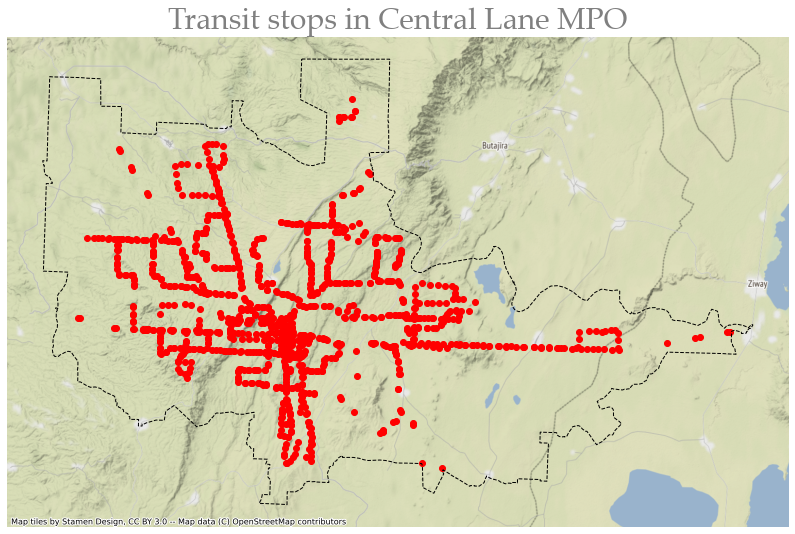

In [13]:
fig, ax = plt.subplots(figsize=(14, 12))
mpo_transit_stops.plot(ax=ax, color='red', aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', aspect=1)
ctx.add_basemap(ax)
plt.title("Transit stops in Central Lane MPO", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [14]:
import os

In [15]:
mpo_transit_stops.to_file(os.path.join(outpath, "transit_stops.shp"))

In [16]:
# get high frequency stops
path = r'T:\Tableau\tableauTransit\Datasources'

In [17]:
import pandas as pd

In [18]:
on_counts = pd.read_csv(os.path.join(path,'AllPassengerCounts.csv'), low_memory=False)

In [19]:
on_counts.head()

,stop,srv,date,block,trip_end,time,route,dir,stop_name,bus,odometer,ons,offs,load,longitude,latitude,Season,MonthYear
0,00001,wkd,2012-10-05 00:00:00,2,1899-12-31 10:56:00,1899-12-31 10:46:00,11,O,E/S of 58th N of Main,1114,84.26,0,3,5.0,-122.926726,44.046335,Fall 2012,October 2012
1,00001,wkd,2012-10-08 00:00:00,2,1899-12-31 12:03:00,1899-12-31 11:48:00,11,O,E/S of 58th N of Main,336,97.44,0,1,4.0,-122.926726,44.046335,Fall 2012,October 2012
2,00001,wkd,2012-10-31 00:00:00,2,1899-12-31 09:56:00,1899-12-31 09:43:00,11,O,E/S of 58th N of Main,1114,71.05,0,1,4.0,-122.926726,44.046335,Fall 2012,October 2012
3,00001,wkd,2012-10-03 00:00:00,67,1899-12-31 21:36:00,1899-12-31 21:25:00,11,O,E/S of 58th N of Main,1002,137.70,1,0,27.0,-122.926726,44.046335,Fall 2012,October 2012
4,00001,wkd,2012-10-24 00:00:00,60,1899-12-31 11:33:00,1899-12-31 11:20:00,11,O,E/S of 58th N of Main,772,53.77,0,1,9.0,-122.926726,44.046335,Fall 2012,October 2012


In [20]:
out_df = on_counts.groupby('stop_name')[['ons']].sum()

In [21]:
type(out_df)

pandas.core.frame.DataFrame

In [22]:
out_df.columns

Index(['ons'], dtype='object')

In [23]:
out_df['name'] = list(out_df.index)

In [24]:
df = mpo_transit_stops.merge(out_df, on='name', how='left')

In [25]:
stops_frequency = gpd.GeoDataFrame(df, geometry='geom')

In [26]:
stops_frequency.head()

,number,name,longitude,latitude,geom,ons
0,00001,E/S of 58th N of Main,-122.926727,44.046333,POINT (4283261.084 876541.193),15416.0
1,00002,E/S of 58th S of D,-122.926224,44.049454,POINT (4283426.923 877674.440),16027.0
2,00004,E/S of 58th S of Thurston Rd,-122.926247,44.052246,POINT (4283450.254 878691.941),6427.0
3,00006,S/S of Thurston W of 64th,-122.916626,44.052948,POINT (4285984.544 878874.556),10110.0
4,00007,S/S of Thurston E of 65th,-122.913231,44.052673,POINT (4286875.484 878748.784),1498.0


In [27]:
type(stops_frequency)

geopandas.geodataframe.GeoDataFrame

In [28]:
stops_frequency.crs = "EPSG:2914"

In [29]:
stops_frequency.head()

,number,name,longitude,latitude,geom,ons
0,00001,E/S of 58th N of Main,-122.926727,44.046333,POINT (4283261.084 876541.193),15416.0
1,00002,E/S of 58th S of D,-122.926224,44.049454,POINT (4283426.923 877674.440),16027.0
2,00004,E/S of 58th S of Thurston Rd,-122.926247,44.052246,POINT (4283450.254 878691.941),6427.0
3,00006,S/S of Thurston W of 64th,-122.916626,44.052948,POINT (4285984.544 878874.556),10110.0
4,00007,S/S of Thurston E of 65th,-122.913231,44.052673,POINT (4286875.484 878748.784),1498.0


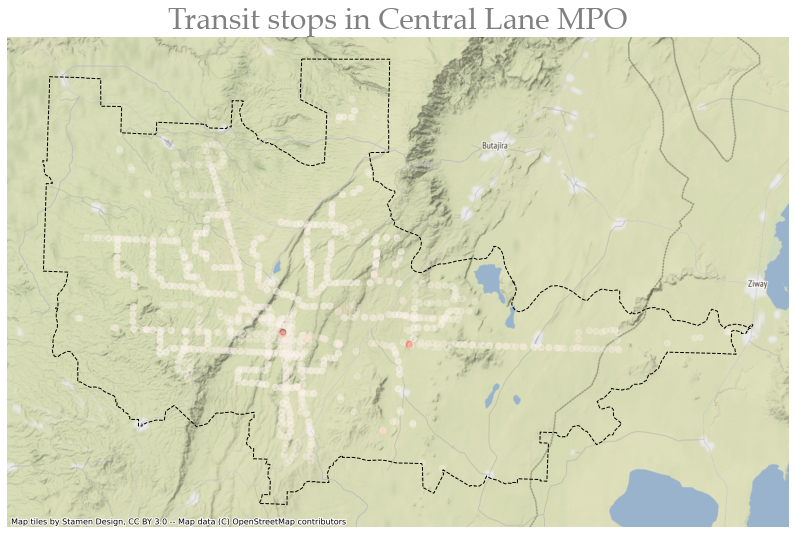

In [30]:
fig, ax = plt.subplots(figsize=(14, 12))
stops_frequency.plot(ax=ax, column='ons', cmap='Reds', alpha=.3, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', aspect=1)
ctx.add_basemap(ax)
plt.title("Transit stops in Central Lane MPO", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [31]:
stops_frequency.to_file(os.path.join(outpath, "stops_frequency.shp"))